In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
import matplotlib.pyplot as plt
import plotly.express as px
from itertools import cycle
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_excel("./alldata.xlsx")
df.head()

,Date,Price,Open,High,Low,Vol.,Change %,FEDFUNDS,Gold
0,2010-07-18,0.1,0.0,0.1,0.1,0.08,0.0,0.18,1204.75
1,2010-07-19,0.1,0.1,0.1,0.1,0.57,0.0,0.18,1190.25
2,2010-07-20,0.1,0.1,0.1,0.1,0.26,0.0,0.18,1181.50
3,2010-07-21,0.1,0.1,0.1,0.1,0.58,0.0,0.18,1191.25
4,2010-07-22,0.1,0.1,0.1,0.1,2.16,0.0,0.18,1187.00


In [3]:
df2 = df[['Date', 'Price']]
df = df.drop('Date', axis=1)

In [4]:
type(df)

pandas.core.frame.DataFrame

In [5]:
training_size=int(len(df)*0.80)
test_size=len(df)-training_size
train_data = df.iloc[0:training_size, :]
test_data = df.iloc[training_size:, :]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (3949, 8)
test_data:  (988, 8)


In [6]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]  # Sử dụng .iloc để chọn dòng và cột theo chỉ số
        dataX.append(a.values)  # Chuyển đổi thành mảng NumPy
        dataY.append(dataset.iloc[i + time_step, 0])  # Giả sử mục tiêu là ở cột đầu tiên
    return np.array(dataX), np.array(dataY)

X_train, y_train = create_dataset(train_data, 30)

# In kích thước của dataX và dataY
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (3918, 30, 8)
y_train shape: (3918,)


In [7]:
X_test, y_test = create_dataset(test_data, 30)

# In kích thước của dataX và dataY
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (957, 30, 8)
y_test shape: (957,)


In [8]:
model = Sequential()
model.add(LSTM(50, input_shape=(30, 8), activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_absolute_percentage_error", optimizer="adam")

# In cấu trúc mô hình
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11800     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11851 (46.29 KB)
Trainable params: 11851 (46.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
history = model.fit(X_train, y_train, epochs=100, batch_size=4, validation_split=0.2)

Epoch 1/100

784/784 [==============================] - 9s 9ms/step - loss: 18269.5781 - val_loss: 57.8298
Epoch 2/100
784/784 [==============================] - 6s 8ms/step - loss: 5820.6826 - val_loss: 125.9725
Epoch 3/100
784/784 [==============================] - 6s 7ms/step - loss: 3201.1411 - val_loss: 99.6668
Epoch 4/100
784/784 [==============================] - 5s 6ms/step - loss: 208.6250 - val_loss: 101.4280
Epoch 5/100
784/784 [==============================] - 5s 6ms/step - loss: 492.9294 - val_loss: 100.8887
Epoch 6/100
784/784 [==============================] - 5s 7ms/step - loss: 270.6893 - val_loss: 97.8028
Epoch 7/100
784/784 [==============================] - 6s 8ms/step - loss: 193.4310 - val_loss: 79.6153
Epoch 8/100
784/784 [==============================] - 6s 8ms/step - loss: 332.5899 - val_loss: 83.6677
Epoch 9/100
784/784 [==============================] - 6s 7ms/step - loss: 1168.8953 - val_loss: 90.3143
Epoch 10/100
784/784 [==============================] -

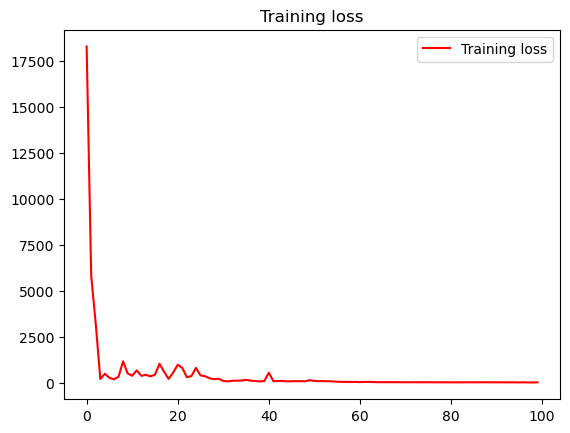

<Figure size 640x480 with 0 Axes>

In [10]:
loss = history.history['loss']

epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.figure()

plt.show()

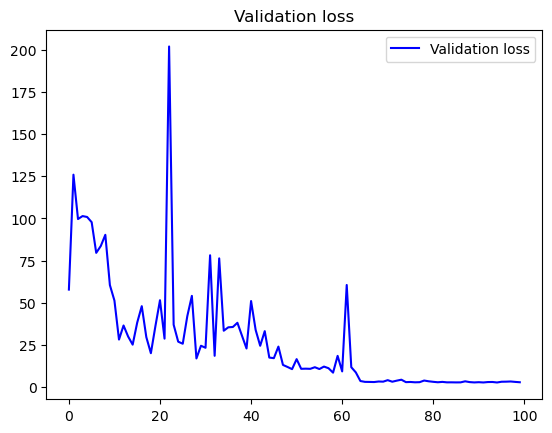

<Figure size 640x480 with 0 Axes>

In [11]:
val_loss = history.history['val_loss']

epochs = range(len(val_loss))
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [12]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

30/30 [==============================] - 0s 5ms/step


((3918, 1), (957, 1))

In [13]:
# Evaluation metrices RMSE and MAE
print("Train data MAPE: ", mean_absolute_percentage_error(y_train,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data MAPE: ", mean_absolute_percentage_error(y_test,test_predict))

Train data MAPE:  0.12440149951556362
-------------------------------------------------------------------------------------
Test data MAPE:  0.025092311279516794


In [14]:
df3 = df2["Price"].values
df3 = df3.reshape(-1, 1)
df3.shape

(4937, 1)

In [15]:
# shift train predictions for plotting

look_back=30
trainPredictPlot = np.empty_like(df3)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(df3)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df2)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': df2['Date'],
                       'original_close': df2['Price'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (4937, 1)
Test predicted data:  (4937, 1)
